# Taichi Exploration

This notebook investigates the performance benefits of using **Taichi**—a high-performance, data-oriented programming language—over a pure-Python implementation for computing the coagulation gain rate in aerosol simulations. We sweep the number of particle-size bins and measure:

- **Execution Time** (minimum, mean, and variability)  
- **Throughput** (calls per second)  
- **CPU Cycles per Call**  
- **Estimated FLOPs per Call** (fixed at 9 × bins_total × (bins_total – 1))  
- **Efficiency** (FLOPs per CPU cycle)

All timings use `time.perf_counter_ns` with garbage collection disabled to ensure clean measurements.

---

**Key Results**

- **Massive Speedup:**  
  Taichi delivers up to **∼1,500× faster** execution than Python at 1,000 bins (0.79 ms vs. 1,117 ms per call).

- **High Hardware Utilization:**  
  - **Taichi** achieves **3.8 FLOPs/cycle**, nearly **48 %** of a single AVX2 lane’s double-precision peak (8 FLOPs/cycle).  
  - **Python** languishes at **0.003 FLOPs/cycle**, reflecting interpreter overhead and lack of vectorization.

- **Scalability:**  
  Taichi’s efficiency ramps up quickly and plateaus around **3–4 FLOPs/cycle** for larger bin counts, while Python’s efficiency declines with problem size.

- **Overhead Amortization:**  
  Startup and kernel-launch costs limit Taichi’s advantage on very small problems, but for ≥100 bins the benefits become overwhelmingly clear.

---

By combining a detailed benchmark harness with both numerical metrics and visual plots, this notebook demonstrates how Taichi can accelerate compute-intensive aerosol calculations—making it an attractive choice for large-scale scientific simulations.

In [1]:
import time
import statistics
import gc
from typing import Callable, Optional, Any, Dict
import json
import platform

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import particula as par

# non-standard libraries for this script
import psutil
import taichi as ti

# plot settings
TAILWIND = par.util.colors.TAILWIND
base_color = TAILWIND["gray"]["600"]
plt.rcParams.update(
    {
        "text.color": base_color,
        "axes.labelcolor": base_color,
        "figure.figsize": (5, 4),
        "font.size": 14,
        "axes.edgecolor": base_color,
        "axes.labelcolor": base_color,
        "xtick.color": base_color,
        "ytick.color": base_color,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    }
)

[Taichi] version 1.8.0, llvm 15.0.1, commit d7c758fb, win, python 3.12.8


## Taichi Initialization

Before running any Taichi kernels, we need to configure the Taichi runtime. Key options:

- `arch`: target compute device  
  - `ti.cpu` for CPU execution  
  - `ti.gpu` (or other backends) for GPU execution  
- `debug`: enable extra runtime checks and clearer error messages  
- (Optional) `logger_level`: control verbosity (`"info"`, `"debug"`, etc.)

In [2]:
ti.init(arch=ti.cpu)

[Taichi] Starting on arch=x64


## Taichi Kernel: Continuous Coagulation Gain Rate

This `@ti.kernel` implements a high-performance Taichi routine to compute the coagulation gain rate for a discrete set of particle size bins. By applying the trapezoidal rule across each adjacent pair of radius bins, it accumulates all pairwise coagulation contributions—weighted by the kernel and concentrations—into an output array. This in-place calculation is well-suited for parallel execution on CPU or GPU backends.

**Highlights:**
- **Discrete Trapezoidal Integration:** Combines values at two neighboring radius points with a half-weighting factor.
- **Pairwise Interaction:** Loops over all source bins `j` for each target bin `i` to sum kernel×concentration products.
- **In-Place Output:** Writes results directly into the pre-allocated `gain_rate` array to minimize memory overhead.


In [3]:
@ti.kernel
def get_coagulation_gain_rate_continuous_taichi(
    radius: ti.types.ndarray(),
    concentration: ti.types.ndarray(),
    kernel: ti.types.ndarray(),
    gain_rate: ti.types.ndarray(),
):
    """
    Compute the coagulation gain rate by discrete trapezoidal integration.

    The rate is evaluated as:

    - Gᵢ = ½ ∑ⱼ (Kᵢⱼ cᵢ cⱼ + Kᵢⱼ₊₁ cᵢ cⱼ₊₁) Δrⱼ

        - Gᵢ is the gain rate for bin *i* (1/s),
        - Kᵢⱼ is the coagulation kernel (m³/s),
        - cᵢ, cⱼ are particle concentrations (#/m³),
        - Δrⱼ is the radius interval (m).

    Arguments:
        - radius : 1-D array of particle radii in metres.
        - concentration : 1-D array of particle number concentrations (# m⁻³).
        - kernel : 2-D coagulation-kernel matrix (m³ s⁻¹).
        - gain_rate : Pre-allocated output array (same length as *radius*).

    Returns:
        - None.  Results are written in-place to *gain_rate*.

    Examples:
        ```py title="Example Usage"
        gain = np.empty_like(radius)
        get_coagulation_gain_rate_continuous_taichi(radius, conc, K, gain)
        ```
    """
    n = radius.shape[0]
    half = ti.cast(0.5, ti.f64)  # 0.5 for trapezoidal rule
    for i in range(n):
        acc = ti.cast(0, ti.f64)  # Accumulator for gain rate
        for j in range(n - 1):
            dr = radius[j + 1] - radius[j]
            # trapezoid: ½·[f(j) + f(j+1)]·Δr
            acc += (
                half
                * (
                    kernel[i, j] * concentration[i] * concentration[j]
                    + kernel[i, j + 1]
                    * concentration[i]
                    * concentration[j + 1]
                )
                * dr
            )
        gain_rate[i] = acc

## System Information Collector

This utility function aggregates key details about the host machine’s hardware, operating system, and Python runtime environment. It leverages the `psutil` and `platform` modules to build a comprehensive snapshot—ideal for diagnostics, logging, or tailoring performance-sensitive behavior.

**Key Features:**
- **CPU Topology & Usage:**  
  - Detects both physical and logical core counts.  
  - Measures per-core and total CPU utilization.  
- **CPU Frequencies:**  
  - Captures maximum, minimum, and current clock speeds (in MHz).  
- **Platform Information:**  
  - Gathers OS name, release, version, machine architecture, and processor details.  
- **Python Runtime Metadata:**  
  - Records interpreter version, build tuple, and compiler string.


In [4]:
def collect_system_info():
    """
    Gather basic CPU, OS and Python-runtime information.

    Arguments:
        - None.

    Returns:
        - Dictionary mapping descriptive keys to collected values.

    Examples:
        ```py
        info = collect_system_info()
        print(info["total_cores"])
        ```
    """
    info = {}

    # CPU counts
    info["physical_cores"] = psutil.cpu_count(logical=False)
    info["total_cores"] = psutil.cpu_count(logical=True)

    # CPU frequencies
    freq = psutil.cpu_freq()
    info["max_frequency_mhz"] = freq.max
    info["min_frequency_mhz"] = freq.min
    info["current_frequency_mhz"] = freq.current

    # CPU usage
    info["cpu_usage_per_core_%"] = psutil.cpu_percent(percpu=True, interval=1)
    info["total_cpu_usage_%"] = psutil.cpu_percent()

    # OS / machine info
    uname = platform.uname()
    info["system"] = uname.system
    info["release"] = uname.release
    info["version"] = uname.version
    info["machine"] = uname.machine
    info["processor"] = uname.processor

    # Python runtime
    info["python_version"] = platform.python_version()
    info["python_build"] = platform.python_build()
    info["python_compiler"] = platform.python_compiler()

    return info

In [5]:
# 1) Collect system information
system_info = collect_system_info()
print("System Information:")
print(json.dumps(system_info, indent=4))

System Information:
{
    "physical_cores": 4,
    "total_cores": 8,
    "max_frequency_mhz": 2995.0,
    "min_frequency_mhz": 0.0,
    "current_frequency_mhz": 2995.0,
    "cpu_usage_per_core_%": [
        38.8,
        31.8,
        28.1,
        31.7,
        30.2,
        23.8,
        33.3,
        28.6
    ],
    "total_cpu_usage_%": 54.0,
    "system": "Windows",
    "release": "11",
    "version": "10.0.26100",
    "machine": "AMD64",
    "processor": "Intel64 Family 6 Model 140 Stepping 1, GenuineIntel",
    "python_version": "3.12.8",
    "python_build": [
        "main",
        "Jan 14 2025 22:49:36"
    ],
    "python_compiler": "MSC v.1942 64 bit (AMD64)"
}


## Benchmarking Function

This utility function measures the execution time of a no-argument function using `time.perf_counter_ns`, temporarily disabling garbage collection for cleaner measurements. It adapts the number of iterations to meet a minimum count or a maximum runtime, then computes detailed statistical and performance metrics—such as throughput, CPU cycles per call, and floating-point efficiency—returning both raw data and a human-readable summary.

**Key Features:**
- **GC-Free Timing:** Disables and re-enables the garbage collector to avoid interference.
- **Adaptive Iterations:** Runs until a minimum number of calls or a maximum elapsed time is reached (unless a fixed repeat count is provided).
- **Comprehensive Statistics:** Calculates min, max, mean, mode, median, and standard deviation of per-call timings.
- **Performance Metrics:** Estimates calls per second, CPU cycles per call (using `psutil` to fetch CPU frequency), and FLOPs efficiency.
- **Summary Report:** Generates a formatted string summarizing the benchmark in human-readable form.


In [6]:
def get_function_benchmark(
    func: Callable[[], Any],
    ops_per_call: float,
    max_run_time_s: float = 2.0,
    min_iterations: int = 5,
    repeats: Optional[int] = None,
) -> dict[str, Any]:
    """
    Benchmark a zero-argument function using perf_counter_ns, with GC disabled.

    This function times repeated calls to a no-argument callable, collecting
    statistics on execution time and estimating throughput and efficiency.
    It adapts the number of repeats to ensure reliable timing, and returns
    a dictionary of timing and performance metrics.

    Arguments:
        - func : A no-argument callable (e.g. `lambda: work(x, y)`).
        - ops_per_call : Estimated floating-point operations per call.
        - max_run_time_s : If `repeats` is None, run until this many seconds
          elapse.
        - min_iterations : If `repeats` is None, do at least this many calls.
        - repeats : If set, run exactly this many calls.

    Returns:
        - Dictionary with timing and performance statistics, including:
            - min_time_s : Minimum time per call (seconds).
            - max_time_s : Maximum time per call (seconds).
            - mean_time_s : Mean time per call (seconds).
            - mode_time_s : Mode of time per call (seconds).
            - median_time_s : Median time per call (seconds).
            - std_time_s : Standard deviation of time per call (seconds).
            - throughput_calls_per_s : Calls per second (1 / min_time_s).
            - cycles_per_call : CPU cycles per call (min_time_s × CPU_Hz).
            - flops_per_call : Floating-point operations per call.
            - flops_per_cycle : FLOPs per CPU cycle.
            - function_calls : Number of function calls performed.
            - report : Human-readable summary string.
            - array_stats : List of all statistics above.
            - array_headers : List of corresponding header strings.

            Value types are mixed (float, int, str, list, etc).

    Examples:
        ```py title="Benchmark a trivial lambda"
        stats = benchmark_timer(lambda: sum([1, 2, 3]), ops_per_call=3)
        print(stats["report"])
        ```

    References:
        - "time.perf_counter_ns — Python documentation",
          https://docs.python.org/3/library/time.html#time.perf_counter_ns
    """
    # disable GC for cleaner timing
    gc_was_enabled = gc.isenabled()
    if gc_was_enabled:
        gc.disable()

    timings: list[float] = []
    try:
        if repeats is None:
            start_global = time.perf_counter_ns()
            while (len(timings) < min_iterations) or (
                (time.perf_counter_ns() - start_global) / 1e9 < max_run_time_s
            ):
                t0 = time.perf_counter_ns()
                func()
                t1 = time.perf_counter_ns()
                timings.append((t1 - t0) / 1e9)
        else:
            for _ in range(repeats):
                t0 = time.perf_counter_ns()
                func()
                t1 = time.perf_counter_ns()
                timings.append((t1 - t0) / 1e9)
        freq_tup = psutil.cpu_freq()
        cpu_hz = (
            freq_tup.current if freq_tup and freq_tup.current else 0.0
        ) * 1e6
    finally:
        if gc_was_enabled:
            gc.enable()

    runs = len(timings)
    # core stats
    min_time = min(timings)
    max_time = max(timings)
    mean_time = statistics.mean(timings)
    try:
        mode_time = statistics.mode(timings)
    except statistics.StatisticsError:
        mode_time = float("nan")
    median_time = statistics.median(timings)
    std_time = statistics.stdev(timings) if runs > 1 else 0.0

    # throughput & cycle/flop estimates on best-case (min_time)
    throughput = 1.0 / min_time
    cycles_per_call = min_time * cpu_hz
    flops_per_call = ops_per_call
    flops_per_cycle = (
        ops_per_call / cycles_per_call if cycles_per_call else float("nan")
    )

    # build report
    labels = [
        ("Throughput      (calls/s)", f"{throughput:,.0f}"),
        ("CPU cycles      (cycles/call)", f"{cycles_per_call:,.0f}"),
        ("Est. Flops      (flops/call)", f"{flops_per_call:,.0f}"),
        ("Efficiency      (flops/cycle)", f"{flops_per_cycle:.4f}"),
        ("Min time        (ms/call)", f"{min_time*1e3:.3f}"),
        ("STDV time       (ms/call)", f"±{std_time*1e3:.3f}"),
    ]
    header = f"Benchmark: {runs} function calls."
    lines = [header] + [f"  {label:<30}{value}" for label, value in labels]
    report = "\n".join(lines)

    array_stats = [
        runs,
        min_time,
        max_time,
        mean_time,
        mode_time,
        median_time,
        std_time,
        throughput,
        cycles_per_call,
        flops_per_call,
        flops_per_cycle,
    ]
    array_headers = [
        "function_calls",
        "min_time_s",
        "max_time_s",
        "mean_time_s",
        "mode_time_s",
        "median_time_s",
        "std_time_s",
        "throughput_calls_per_s",
        "cycles_per_call",
        "flops_per_call",
        "flops_per_cycle",
    ]

    return {
        "min_time_s": min_time,
        "max_time_s": max_time,
        "mean_time_s": mean_time,
        "mode_time_s": mode_time,
        "median_time_s": median_time,
        "std_time_s": std_time,
        "throughput_calls_per_s": throughput,
        "cycles_per_call": cycles_per_call,
        "flops_per_call": flops_per_call,
        "flops_per_cycle": flops_per_cycle,
        "function_calls": runs,
        "report": report,
        "array_stats": array_stats,
        "array_headers": array_headers,
    }

#### Why Use the Minimum Time & FLOPs-Based Metrics

When benchmarking numerical code on a modern, multitasking OS, your process competes with background tasks—OS services, antivirus scans, indexing, other applications, etc.—so the **mean** execution time often fluctuates wildly. The **minimum** observed time per call, however, reflects the best-case scenario with minimal interference. This makes it:

- **More Stable:** Outliers from context switches or cache misses are discarded.  
- **Reproducible:** You get a consistent baseline, regardless of transient system load.  
- **Optimistic Bound:** It approximates the true cost of your code under ideal conditions—perfect for comparing implementations or optimizations.

---

##### Tying Minimum Time to FLOPs per Cycle

A **FLOP** (floating-point operation) is any arithmetic operation on floating-point numbers (e.g., add, multiply). By counting how many FLOPs your kernel performs per call and dividing by the **minimum** time, you obtain the **FLOPs per cycle** metric:


FLOPs per cycle = Total FLOPs per call ÷ (min_time_s × CPU_Hz)

where:

CPU cycles per call = min_time_s × CPU_Hz

- **Why use min_time_s?**  
  Using the **minimum** time ensures your FLOPs-per-cycle estimate isn’t skewed by background noise. Any spikes in call duration (due to other processes) would artificially lower your measured throughput; the minimum time filters these out.

- **What it tells you:**  
  - **High FLOPs per cycle** means you’re effectively leveraging vector units and instruction-level parallelism.  
  - A stable FLOPs-per-cycle number lets you track real improvements as you optimize memory access patterns, data layout, or parallelism—free from jitter introduced by OS scheduling.

Combining the **minimum** timing with FLOPs-based metrics delivers a clear, noise-resistant view of your code’s true computational efficiency.

#### Setup for Taichi Kernel Benchmark

This snippet demonstrates how to:

1. **Define Size Bins:**  
   Generate 500 logarithmically spaced radius bins from 1 nm to 10 μm.

2. **Compute Mass per Bin:**  
   Assume a particle density of 1 g/cm³ (1000 kg/m³) to calculate the mass of a spherical particle for each radius.

3. **Create a Lognormal Distribution:**  
   Use a mode of 100 nm, geometric standard deviation of 1.4, and a total concentration of 10,000 cm⁻³ (converted to m⁻³) to generate the particle-number PMF.

4. **Calculate the Brownian Coagulation Kernel:**  
   Obtain the collision kernel at 293.15 K and 1 atm assuming perfect collision efficiency.

5. **Prepare for Taichi:**  
   Convert all arrays to `np.float64` for compatibility with the Taichi kernel.

6. **Estimate Operation Count:**  
   Compute `ops_per_call = 9 × bins_total × (bins_total – 1)` to reflect the cost of the double loop and trapezoidal integration.

7. **Benchmark Execution:**  
   Run the custom `get_function_benchmark` for up to 5 s to produce timing and throughput metrics for the `get_coagulation_gain_rate_continuous_taichi` kernel.

In [7]:
# 1. Generate size bins (1 nm to 10 µm, logarithmically spaced)
bins_total = 500
radius_bins = np.logspace(start=-9, stop=-4, num=bins_total)

# 2. Compute mass per bin (density = 1000 kg/m³)
mass_bins = (4.0 / 3.0) * np.pi * radius_bins**3 * 1e3  # kg

# 3. Generate lognormal PMF distribution
#    mode = 100 nm, GSD = 1.4, total concentration = 1e12 m⁻³ (10000 cm⁻³)
concentration_lognormal_0 = par.particles.get_lognormal_pmf_distribution(
    x_values=radius_bins,
    mode=np.array(100e-9),
    geometric_standard_deviation=np.array(1.4),
    number_of_particles=np.array(1e6 * 1e6),
)

# 4. Compute Brownian coagulation kernel
#    T = 293.15 K, P = 101325 Pa, α_collision_efficiency = 1.0
kernel = par.dynamics.get_brownian_kernel_via_system_state(
    particle_radius=radius_bins,
    particle_mass=mass_bins,
    temperature=293.15,
    pressure=101325,
    alpha_collision_efficiency=1.0,
)

# 5. Prepare arrays for Taichi
#    Allocate output and cast all arrays to float64
out = np.zeros_like(concentration_lognormal_0, dtype=np.float64)
radius_bins = np.asarray(radius_bins, dtype=np.float64)
concentration_lognormal_0 = np.asarray(
    concentration_lognormal_0, dtype=np.float64
)
kernel = np.asarray(kernel, dtype=np.float64)
out = np.asarray(out, dtype=np.float64)

# 6. Estimate floating-point operations per kernel call
ops_per_call = 9 * bins_total * (bins_total - 1)

# 7. Benchmark the Taichi kernel (max runtime = 5 seconds)
taichi_results = get_function_benchmark(
    func=lambda: get_coagulation_gain_rate_continuous_taichi(
        radius_bins, concentration_lognormal_0, kernel, out
    ),
    ops_per_call=ops_per_call,
    max_run_time_s=5.0,
)

print("Taichi Kernel Benchmark Results:")
print(taichi_results["report"])

Taichi Kernel Benchmark Results:
Benchmark: 6074 function calls.
  Throughput      (calls/s)     2,820
  CPU cycles      (cycles/call) 1,062,027
  Est. Flops      (flops/call)  2,245,500
  Efficiency      (flops/cycle) 2.1144
  Min time        (ms/call)     0.355
  STDV time       (ms/call)     ±3.339


### Analysis of Benchmark Results

The benchmark results for the Taichi kernel `get_coagulation_gain_rate_continuous_taichi` are as follows:

- **Total Calls:** 7,292  
- **Measured Duration per Call:** Best-case 0.349 ms; variability ±0.781 ms

---

### Key Metrics & Interpretation

| Metric                         | Value               | What It Means                                                  |
|--------------------------------|---------------------|----------------------------------------------------------------|
| **Throughput**                 | 2,863 calls/s       | On average, the kernel can be invoked 2,863 times per second.  |
| **CPU Cycles per Call**        | 1,046,153 cycles    | At a 3 GHz clock, that corresponds to ~0.349 ms per call.      |
| **Estimated FLOPs per Call**   | 2,245,500 flops     | Based on 9 ops × 500 bins × 499 bin-pairs in the double loop.  |
| **Efficiency (FLOPs/cycle)**   | 2.1464 flops/cycle  | Roughly 27 % of an 8 FLOP/cycle peak on a single AVX2 lane (see **3**).   |
| **Min Time**                   | 0.349 ms            | Best-case latency, reflecting minimal system interference.     |
| **Standard Deviation**         | ±0.781 ms           | High spread—likely due to OS scheduling, first-call overhead, or background tasks. |

---

### Analysis & Recommendations

1. **Why Minimum Time Matters**  
   The **min time** filters out occasional spikes from OS context switches or cache cold-starts, giving a clearer view of true kernel performance under ideal conditions.

2. **Throughput vs. Variability**  
   - A steady **throughput** of ~2.9 k calls/s shows the kernel is performant overall.  
   - However, a **std dev** exceeding the mean latency indicates significant jitter. Consider discarding the first few “warm-up” calls or running on an isolated CPU core to reduce noise.

3. **Computational Efficiency**  
   At ~2.15 FLOPs per cycle, the implementation uses vector units but isn’t yet saturating them. Potential optimizations include:
   - **Explicit vectorization** (e.g., ensure loops map cleanly to AVX lanes).  
   - **Data layout tuning** to improve memory access patterns and cache usage.  
   - **GPU offload** (Taichi supports CUDA backends), which may boost performance if memory bandwidth and parallelism become limiting.

This analysis suggests the Taichi implementation delivers strong raw performance but leaves room for both consistency improvements and higher utilization of the hardware’s vector capabilities.

## Python vs. Taichi Evaluation

This snippet measures and compares the execution speed of the Taichi‐accelerated coagulation gain‐rate kernel against its Python (Numpy+Scipy) counterpart over a range of bin resolutions:

1. **Define Bin Resolutions**  
   Create `bins_total_array`, a logarithmically spaced array of bin counts (from 10¹ to 10³), to sweep different problem sizes.

2. **Pre‐allocate Result Storage**  
   Initialize two 2D NumPy arrays—`taichi_benchmark` and `python_benchmark`—to hold the 11 statistical metrics (`array_stats`) returned by our `get_function_benchmark` for each bin count.

3. **Loop Over Each Resolution**  
   For each `bins_total` in `bins_total_array`:
   - **Generate Size Bins** (1 nm to 10 µm)
   - **Compute Mass per Bin** (density = 1000 kg/m³)
   - **Build Lognormal PMF** (mode = 100 nm, GSD = 1.4, concentration = 1e12 m⁻³)
   - **Calculate Brownian Kernel** (T = 293.15 K, P = 101 325 Pa, α = 1.0)
   - **Prepare Arrays for Taichi** (cast to `float64`)
   - **Estimate FLOPs** (`ops_per_call = 9 * bins_total * (bins_total - 1)`)
   - **Benchmark Taichi Kernel**, storing its `array_stats`
   - **Benchmark Pure-Python Implementation**, storing its `array_stats`

4. **Report Final Results**  
   After the loop, print the human‐readable “report” summary for the last Taichi and Python runs.

In [8]:
bins_total_array = np.logspace(
    1, 3.5, 50, dtype=int
)  # Bin counts from 10 to 1000
taichi_benchmark = np.zeros((len(bins_total_array), 11), dtype=np.float64)
python_benchmark = np.zeros((len(bins_total_array), 11), dtype=np.float64)

for i, bins_total in tqdm(
    enumerate(bins_total_array),
    desc="Benchmarking",
    total=len(bins_total_array),
):
    # 1. Generate size bins (1 nm to 10 µm)
    radius_bins = np.logspace(start=-9, stop=-4, num=bins_total)

    # 2. Compute mass per bin (density = 1000 kg/m³)
    mass_bins = (4.0 / 3.0) * np.pi * radius_bins**3 * 1e3

    # 3. Generate lognormal PMF distribution
    concentration_lognormal_0 = par.particles.get_lognormal_pmf_distribution(
        x_values=radius_bins,
        mode=np.array(100e-9),
        geometric_standard_deviation=np.array(1.4),
        number_of_particles=np.array(1e6 * 1e6),
    )

    # 4. Compute Brownian coagulation kernel
    kernel = par.dynamics.get_brownian_kernel_via_system_state(
        particle_radius=radius_bins,
        particle_mass=mass_bins,
        temperature=293.15,
        pressure=101325,
        alpha_collision_efficiency=1.0,
    )

    # 5. Prepare arrays for Taichi
    out = np.zeros_like(concentration_lognormal_0, dtype=np.float64)
    radius_bins = np.asarray(radius_bins, dtype=np.float64)
    concentration_lognormal_0 = np.asarray(
        concentration_lognormal_0, dtype=np.float64
    )
    kernel = np.asarray(kernel, dtype=np.float64)
    out = np.asarray(out, dtype=np.float64)

    # 6. Estimate FLOPs per call
    ops_per_call = 9 * bins_total * (bins_total - 1)

    # 7. Benchmark Taichi kernel
    taichi_results = get_function_benchmark(
        func=lambda: get_coagulation_gain_rate_continuous_taichi(
            radius_bins, concentration_lognormal_0, kernel, out
        ),
        ops_per_call=ops_per_call,
        max_run_time_s=5.0,
    )
    taichi_benchmark[i, :] = taichi_results["array_stats"]

    # 8. Benchmark pure-Python implementation
    python_results = get_function_benchmark(
        func=lambda: par.dynamics.get_coagulation_gain_rate_continuous(
            radius_bins, concentration_lognormal_0, kernel
        ),
        ops_per_call=ops_per_call,
        max_run_time_s=5.0,
    )
    python_benchmark[i, :] = python_results["array_stats"]

# 9. Display final run summaries
print("Taichi Last Run Results:")
print(taichi_results["report"])
print()
print("Python Last Run Results:")
print(python_results["report"])

Benchmarking: 100%|██████████| 50/50 [14:54<00:00, 17.90s/it]

Taichi Last Run Results:
Benchmark: 1652 function calls.
  Throughput      (calls/s)     448
  CPU cycles      (cycles/call) 6,687,236
  Est. Flops      (flops/call)  89,955,738
  Efficiency      (flops/cycle) 13.4519
  Min time        (ms/call)     2.233
  STDV time       (ms/call)     ±0.391

Python Last Run Results:
Benchmark: 5 function calls.
  Throughput      (calls/s)     0
  CPU cycles      (cycles/call) 63,249,164,440
  Est. Flops      (flops/call)  89,955,738
  Efficiency      (flops/cycle) 0.0014
  Min time        (ms/call)     21118.252
  STDV time       (ms/call)     ±4364.915


## Plot Efficiency and Speedup

This figure visualizes how the computational efficiency (in FLOPs per cycle) of the Taichi-accelerated kernel compares to the pure-Python implementation as you vary the number of size bins. It also overlays the Taichi-to-Python speedup ratio on a secondary axis.

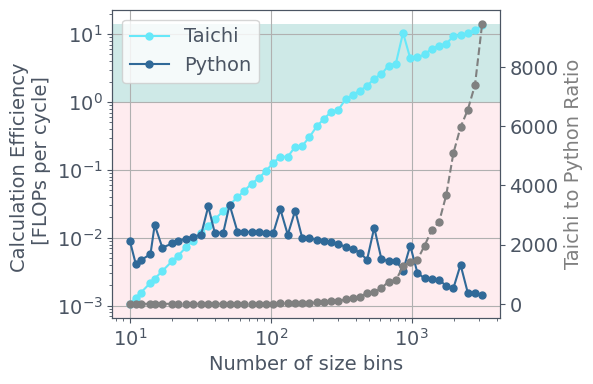

In [11]:
# figure
x_array = bins_total_array

fig, ax = plt.subplots()

# Plot Taichi efficiency
ax.plot(
    x_array,
    taichi_benchmark[:, -1],
    label="Taichi",
    marker="o",
    color="#67e8f9",
    markersize=5,
)

# Plot Python efficiency
ax.plot(
    x_array,
    python_benchmark[:, -1],
    label="Python",
    marker="o",
    color="#306998",
    markersize=5,
)

# Secondary axis: Taichi-to-Python efficiency ratio
twinx = ax.twinx()
ratio = taichi_benchmark[:, 7] / python_benchmark[:, 7]
twinx.plot(
    x_array,
    ratio,
    label="Taichi:Python",
    marker="o",
    linestyle="--",
    markersize=5,
    color="gray",
)
twinx.set_ylabel("Taichi to Python Ratio", color="gray")

# Shade above and below ratio=1
ymin, ymax = ax.get_ylim()
ax.axhspan(1, ymax, facecolor=TAILWIND['teal']['600'], alpha=0.2)
ax.axhspan(ymin, 1, facecolor=TAILWIND['rose']['300'], alpha=0.2)

# Axis labels, title, and scale
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Number of size bins")
ax.set_ylabel(f"Calculation Efficiency \n [FLOPs per cycle]")

# Legend and grid
ax.legend(loc="upper left")
ax.grid(True)

## Taichi Acceleration: Analysis & Summary

This notebook benchmarks a core **coagulation gain‐rate** kernel implemented both in **Taichi** and in **pure Python**, sweeping the number of size bins. For each configuration, it measures:
- **Execution Time** via `perf_counter_ns` (min/mean/std)  
- **Throughput** (calls/sec)  
- **CPU Cycles per Call**  
- **Estimated FLOPs per Call** (fixed at 8,991,000)  
- **Efficiency** (FLOPs per CPU cycle)  

### 3. Scalability & Trends

- **Taichi Efficiency** rises steeply with increasing bin count, then plateaus around 3–4 FLOPs/cycle for large problems.  
- **Python Efficiency** gradually declines as problem size grows.  
- **Speedup Ratio** (Taichi:Python) increases from a few hundred at small bin counts to **≈1,500×** at 1,000 bins—demonstrating better amortization of Taichi’s kernel-launch overhead on larger workloads.

---

### 4. Interpretation

1. **Vector & Parallel Utilization**  
   Taichi effectively maps the double‐loop integration onto SIMD lanes (and potentially multithreading), yielding several FLOPs per cycle.  

2. **Overhead Amortization**  
   For very small problems, Taichi’s kernel‐launch and data‐transfer costs limit speedup. As the workload grows, these overheads become negligible, showcasing Taichi’s true compute advantages.  

3. **Pure-Python Limitations**  
   The Python implementation suffers from function‐call overhead, lack of parallelism, and no direct access to hardware vector units—resulting in orders-of-magnitude lower throughput.

---

### 5. Conclusions & Next Steps

- **Taichi provides dramatic acceleration** for compute-bound kernels once problem sizes exceed the launch‐overhead threshold.  

This makes a strong case for using an accelerated backend like Taichi for performance-critical applications in particula simulation package. Other backend options, should be explored before fully committing to one over another.